In [1]:
import pandas as pd
import os
import json
import numpy as np
from glob import glob
import simpledorff
from scipy.stats import mannwhitneyu
import pingouin as pg
import seaborn as sns
from transformers import BartTokenizerFast

from src.models.CORAL_BART.trainer import MultiTaskEvalPrediction
from src.models.CORAL_BART.metrics import get_seq2seq_eval

In [2]:
FINAL_RESULTS_PATH = "../results/final/"
final_results = {
    "Graph Loss":{"file":"deluxe.jsonl"},
    "Seq2Seq Loss Only":{"file":"seq2seq.jsonl"},
    "SequenceR": {"file":"sequenceR_results.jsonl"}
}

In [3]:
def load_jsonl(path):
    data = []
    with open(path) as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

In [4]:
for name, result in final_results.items():
    eval_output = load_jsonl(os.path.join(FINAL_RESULTS_PATH,result["file"]))
    eval_output["method"] = name
    eval_output = eval_output[~eval_output["input"].str.contains("<-")]
    final_results[name]["df"] = eval_output
    

In [5]:
eval_output[~eval_output["input"].str.contains("<-")]

,input,label,prediction,method
0,"return model, history",elapsed_time = time.time() - start_time\nretur...,"return model, y_train",SequenceR
1,model=Sequential()\nmodel.add(Embedding(vocabu...,model=Sequential()\nmodel.add(Embedding(vocabu...,model = (() model.fit(get_training_dataset...,SequenceR
2,"return model, history",elapsed_time = time.time() - start_time\nretur...,"return model, y_train",SequenceR
3,"xtrain_ros, xvalid_ros, ytrain_ros, yvalid_ros...","xtrain_ros, xvalid_ros, ytrain_ros, yvalid_ros...","<unk>, <unk>, <unk> = train_test_split(<unk>, ...",SequenceR
4,model=Sequential()\nmodel.add(Embedding(vocabu...,model=Sequential()\nmodel.add(Embedding(vocabu...,model = (() model.compile(get_training_dat...,SequenceR
...,...,...,...,...
3479,qs2 = np.log(qs/(1-qs))*.65,qs2 = np.log(qs/(1-qs))*.065,<unk> = np.array(<unk>/(1-<unk>))*..,SequenceR
3480,# Add some random noise to simulate prediction...,# Add some random noise to simulate prediction...,# Play of random set to <unk> predictions pred...,SequenceR
3481,# So then the SPL for this series and quantile...,# So then the SPL for this series and quantile...,Create the the <unk> for <unk> and set <un...,SequenceR
3482,# We need the spl scale\nw_df = add_spl_scale(...,# We need the spl scale\nw_df = add_spl_scale(...,"# We the the <unk> <unk> = <unk>(<unk>, <unk>...",SequenceR


In [6]:
def display_sample(df):
    for index, row in df.iterrows():
        print("-"*20 + "Input" +"-"*20 )
        print(row["input"])
        print("-"*20 + "Label" +"-"*20 )
        print(row["label"])
        print("-"*20 + "Pred" +"-"*20 )
        print(row["prediction"])
        print("="*40) 

display_sample(final_results["Graph Loss"]["df"].iloc[30:35])

--------------------Input--------------------
x = Flatten()(merge)
x = Dropout(0.2)(x)
predictions = Dense(y_dim, activation ='sigmoid')(x)
--------------------Label--------------------
x = Flatten()(merge)
x = Dropout(dropout)(x)
predictions = Dense(y_dim, activation ='sigmoid')(x)
--------------------Pred--------------------
x = Flatten()(merge)
x = Dropout(1.1)(x)
predictions = Dense(y_dim, activation ='sigmoid')(x)
--------------------Input--------------------
model = model3(output_dim=8, max_length=max_length,y_dim=5,filter_sizes = [3,4,5])
from IPython.display import Image
Image(filename='shared_input_layer.png') 
--------------------Label--------------------
model = model(output_dim=16, max_length=max_length,y_dim=5,filter_sizes = [3,4,5],pooling ='max',dropout=0.5)
from IPython.display import Image
Image(filename='shared_input_layer.png') 
--------------------Pred--------------------
model = model3(output_dim=8, max_length=max_length,y_dim=3,filter_sizes = [3,3,3])
from IPython

In [7]:
np.random.seed(100)
indices = len(final_results["Graph Loss"]["df"])
selection = np.random.choice(indices, size=50, replace=False)

In [8]:
results_for_labeling = []
for i in selection:
    alternatives = []
    for name, result in final_results.items():
        df = result["df"]
        alternatives.append(df.iloc[i])
    np.random.shuffle(alternatives)
    results_for_labeling.extend(alternatives)

In [9]:
results_for_labeling = pd.DataFrame(results_for_labeling)

In [10]:
#results_for_labeling.to_csv("")

In [11]:
#pd.DataFrame(results_for_labeling)[["input","prediction"]].to_csv("to_label.csv")

In [12]:
#pd.DataFrame(results_for_labeling).to_csv("master_to_label_2.csv")

In [13]:
results_for_labeling[results_for_labeling["method"] == "Graph Loss"][["input","prediction"]].to_csv("graph_loss_only.csv")

## Analyze Results

In [14]:
def load_hand_label(path,method_key,name=None):
    df = pd.read_csv(path, names = ["input","prediction","syntax","reasonableness","acceptability"])
    if name is not None:
        df["rater"] = name
    df["method"] = method_key
    df["example"] = df.index 
    df["input_id"] = df.index // 3
    return df

def load_all_labels(glob_str,method_key):
    all_dfs = []
    letters = list(map(chr, range(65, 91)))
    for i,path in enumerate(glob(glob_str)):
        df = load_hand_label(path,method_key,name=letters[i])
        all_dfs.append(df)
    return pd.concat(all_dfs, axis=0)
        

In [15]:
all_hand_labels = load_all_labels("./hand_labels/*.csv",results_for_labeling["method"].values)
all_hand_labels.head()

,input,prediction,syntax,reasonableness,acceptability,rater,method,example,input_id
0,GPU_COUNT = 1\nIMAGES_PER_GPU = 4 # a memory e...,_COUNT = 1\nIMAGES_PER_GPU = 5 # a memory erro...,5,3,3,A,Seq2Seq Loss Only,0,0
1,GPU_COUNT = 1\nIMAGES_PER_GPU = 4 # a memory e...,GPU_COUNT = 1\nIMAGES_PER_GPU = 5 # a memory e...,5,4,4,A,Graph Loss,1,0
2,GPU_COUNT = 1\nIMAGES_PER_GPU = 4 # a memory e...,BATCH_SIZE = 1 TRAIN_BATCH_SIZE = 4 # a the no...,2,1,1,A,SequenceR,2,0
3,"train_df2 = train_df\ntrain_df2[""label""] = tra...","train_df2 = train_df\ntrain_df1[""label""] = tra...",5,4,4,A,Graph Loss,3,1
4,"train_df2 = train_df\ntrain_df2[""label""] = tra...","<unk> = train_df <unk>[""target""] = train_df[""t...",2,2,1,A,SequenceR,4,1


In [16]:
all_hand_labels.groupby("method")[["syntax","reasonableness","acceptability"]].median().round(2)

,syntax,reasonableness,acceptability
method,,,
Graph Loss,5,3,3
Seq2Seq Loss Only,4,3,2
SequenceR,2,1,1


<AxesSubplot:xlabel='method', ylabel='score'>

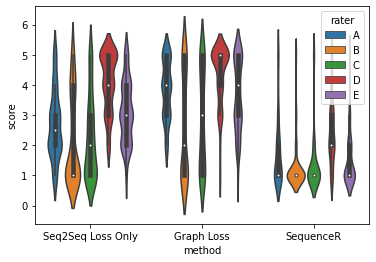

In [17]:
label_melt = all_hand_labels.melt(id_vars=["method","rater"], 
                     value_vars=["syntax","reasonableness","acceptability"],
                     var_name = "metric",
                     value_name = "score")
sns.violinplot(data=label_melt, x = "method",hue="rater", y="score")

In [18]:
label_melt

,method,rater,metric,score
0,Seq2Seq Loss Only,A,syntax,5
1,Graph Loss,A,syntax,5
2,SequenceR,A,syntax,2
3,Graph Loss,A,syntax,5
4,SequenceR,A,syntax,2
...,...,...,...,...
2245,Graph Loss,E,acceptability,2
2246,Seq2Seq Loss Only,E,acceptability,2
2247,Graph Loss,E,acceptability,2
2248,SequenceR,E,acceptability,1


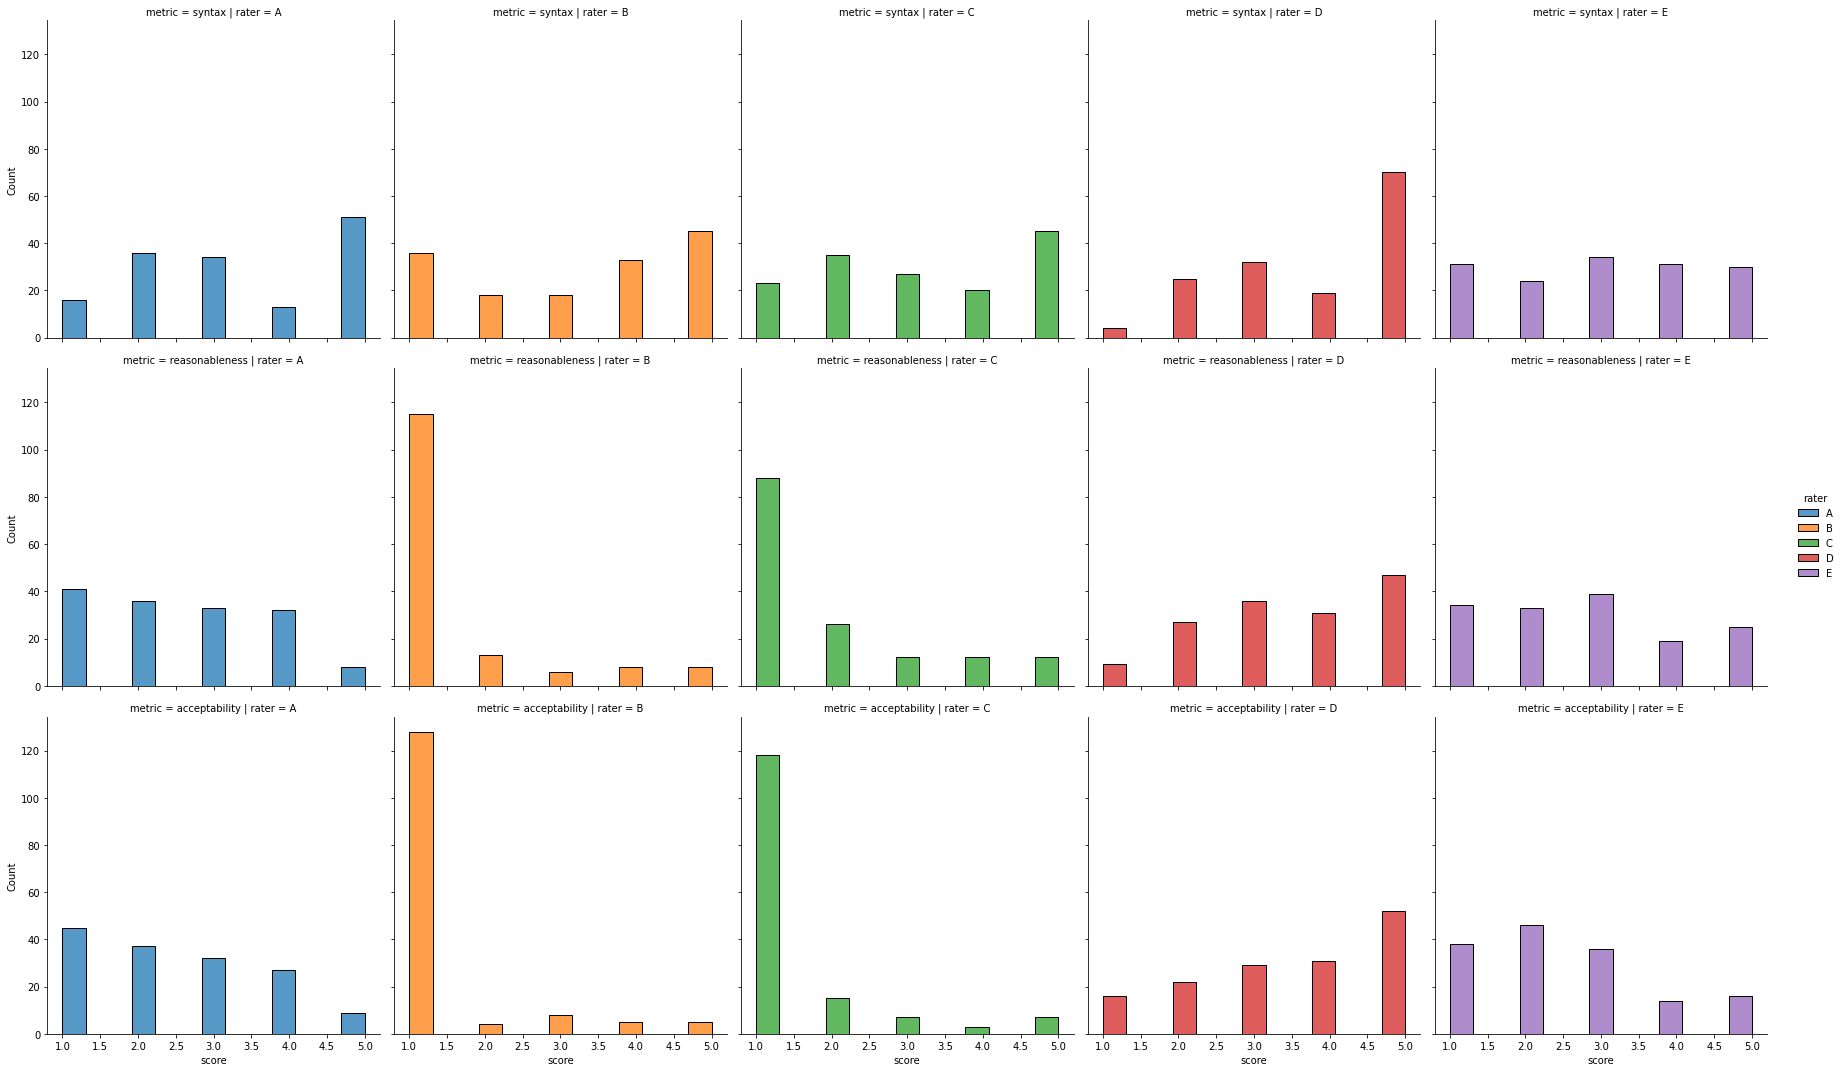

In [19]:
sns.displot( data = label_melt, x="score", col="rater", row="metric", hue="rater")

In [20]:
all_hand_labels

,input,prediction,syntax,reasonableness,acceptability,rater,method,example,input_id
0,GPU_COUNT = 1\nIMAGES_PER_GPU = 4 # a memory e...,_COUNT = 1\nIMAGES_PER_GPU = 5 # a memory erro...,5,3,3,A,Seq2Seq Loss Only,0,0
1,GPU_COUNT = 1\nIMAGES_PER_GPU = 4 # a memory e...,GPU_COUNT = 1\nIMAGES_PER_GPU = 5 # a memory e...,5,4,4,A,Graph Loss,1,0
2,GPU_COUNT = 1\nIMAGES_PER_GPU = 4 # a memory e...,BATCH_SIZE = 1 TRAIN_BATCH_SIZE = 4 # a the no...,2,1,1,A,SequenceR,2,0
3,"train_df2 = train_df\ntrain_df2[""label""] = tra...","train_df2 = train_df\ntrain_df1[""label""] = tra...",5,4,4,A,Graph Loss,3,1
4,"train_df2 = train_df\ntrain_df2[""label""] = tra...","<unk> = train_df <unk>[""target""] = train_df[""t...",2,2,1,A,SequenceR,4,1
...,...,...,...,...,...,...,...,...,...
145,question_1 = Word_Extractor.transform(train.ix...,question_1 = Word_Extractor.transform(train.ix...,5,2,2,E,Graph Loss,145,48
146,question_1 = Word_Extractor.transform(train.ix...,"_1 = Word_equation.transform(train.ix[:,'quest...",3,3,2,E,Seq2Seq Loss Only,146,48
147,"train_clicked = pd.merge(train, events, how='l...","train_clicked = pd.merge(train, events, how='l...",4,2,2,E,Graph Loss,147,49
148,"train_clicked = pd.merge(train, events, how='l...","<unk> = pd.merge(train, train_vectors, how='le...",2,1,1,E,SequenceR,148,49


Spearman $\rho$:

In [21]:
all_hand_labels.pivot(index="example", values=["syntax"],columns="rater").columns

MultiIndex([('syntax', 'A'),
            ('syntax', 'B'),
            ('syntax', 'C'),
            ('syntax', 'D'),
            ('syntax', 'E')],
           names=[None, 'rater'])

In [22]:
pg.pairwise_corr(all_hand_labels.pivot(index="example", values=["syntax"],columns="rater"),
                 method="spearman")["r"].mean()

0.6644187176883802

In [23]:
pg.pairwise_corr(all_hand_labels.pivot(index="example", values=["reasonableness"],columns="rater"),
                 method="spearman")["r"].mean()

0.5343205787299355

In [24]:
pg.pairwise_corr(all_hand_labels.pivot(index="example", values=["acceptability"],columns="rater"),
                 method="spearman")["r"].mean()

0.4623053199521072

## Significance Testing

In [25]:
pg.pairwise_ttests(dv='syntax', within='method', data=all_hand_labels, parametric=False).round(3)


,Contrast,A,B,Paired,Parametric,W-val,Tail,p-unc,hedges
0,method,Seq2Seq Loss Only,Graph Loss,True,False,1674.0,two-sided,0.0,-0.750
1,method,Seq2Seq Loss Only,SequenceR,True,False,2971.0,two-sided,0.0,1.065
2,method,Graph Loss,SequenceR,True,False,1074.0,two-sided,0.0,1.830


In [26]:
pg.pairwise_ttests(dv="reasonableness", within='method', subject="example",data=all_hand_labels,
                  parametric=False).round(3)

,Contrast,A,B,Paired,Parametric,W-val,Tail,p-unc,hedges
0,method,Seq2Seq Loss Only,Graph Loss,True,False,2660.5,two-sided,0.0,-0.400
1,method,Seq2Seq Loss Only,SequenceR,True,False,361.5,two-sided,0.0,1.035
2,method,Graph Loss,SequenceR,True,False,78.0,two-sided,0.0,1.478


In [27]:
pg.pairwise_ttests(dv="acceptability", within='method',
                    subject='example', data=all_hand_labels,
                  parametric=False).round(3)

,Contrast,A,B,Paired,Parametric,W-val,Tail,p-unc,hedges
0,method,Seq2Seq Loss Only,Graph Loss,True,False,2211.0,two-sided,0.0,-0.352
1,method,Seq2Seq Loss Only,SequenceR,True,False,422.0,two-sided,0.0,0.882
2,method,Graph Loss,SequenceR,True,False,64.5,two-sided,0.0,1.230


## How do these labels relate to what we see in the automatic evaluation?

In [28]:
path_to_tokenizer='../tokenizer/'
tokenizer = BartTokenizerFast.from_pretrained(path_to_tokenizer)

In [30]:
example_tokens = all_hand_labels.drop_duplicates(subset = "example")[["input","prediction","input_id","example","method"]] 
example_tokens["input_tokens"] = example_tokens["input"].map(lambda x: tokenizer(x, add_special_tokens=False)["input_ids"])
example_tokens["prediction_tokens"] = example_tokens["prediction"].map(lambda x: tokenizer(x, add_special_tokens=False)["input_ids"])

In [31]:
def seq2seq_eval_row(row,seq2seq_eval):
    predictions = MultiTaskEvalPrediction(predictions=row["prediction_tokens"],
                                          label_ids = row["input_tokens"],
                                          input_labels = [[]],
                                          input_logits = [[]],
                                          input_ids = [[]],
                                          loss_mask = [[]])
    return seq2seq_eval(predictions)

seq2seq_eval = get_seq2seq_eval(tokenizer)
seq2seq_result = example_tokens.groupby(["example","method"]).apply(lambda x: seq2seq_eval_row(x,seq2seq_eval))
per_example_auto_eval = pd.DataFrame(list(seq2seq_result), index = seq2seq_result.index)

In [33]:
per_example_scores = all_hand_labels.groupby("example").median()
example_evals = per_example_auto_eval.merge(per_example_scores,left_index=True,right_index=True)
example_evals

,,rouge-l-p,rouge-l-f,rouge-l-r,span_aware_rouge_l_p,span_aware_rouge_l_r,span_aware_rouge_l_f,avg_edit_distance,syntax,reasonableness,acceptability,input_id
example,method,,,,,,,,,,,
0,Seq2Seq Loss Only,0.950000,0.950000,0.950000,1.0,1.0,1.0,2.0,5,4,3,0
1,Graph Loss,0.950000,0.950000,0.950000,1.0,1.0,1.0,1.0,5,5,5,0
2,SequenceR,0.388889,0.368421,0.350000,1.0,1.0,1.0,24.0,4,2,1,0
3,Graph Loss,0.962963,0.981132,1.000000,1.0,1.0,1.0,1.0,5,4,4,1
4,SequenceR,0.791667,0.760000,0.730769,0.0,0.0,0.0,26.0,1,2,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
145,Graph Loss,1.000000,1.000000,1.000000,1.0,1.0,1.0,1.0,5,2,2,48
146,Seq2Seq Loss Only,0.933333,0.933333,0.933333,1.0,1.0,1.0,6.0,4,3,2,48
147,Graph Loss,0.900000,0.947368,1.000000,1.0,1.0,1.0,19.0,4,2,2,49


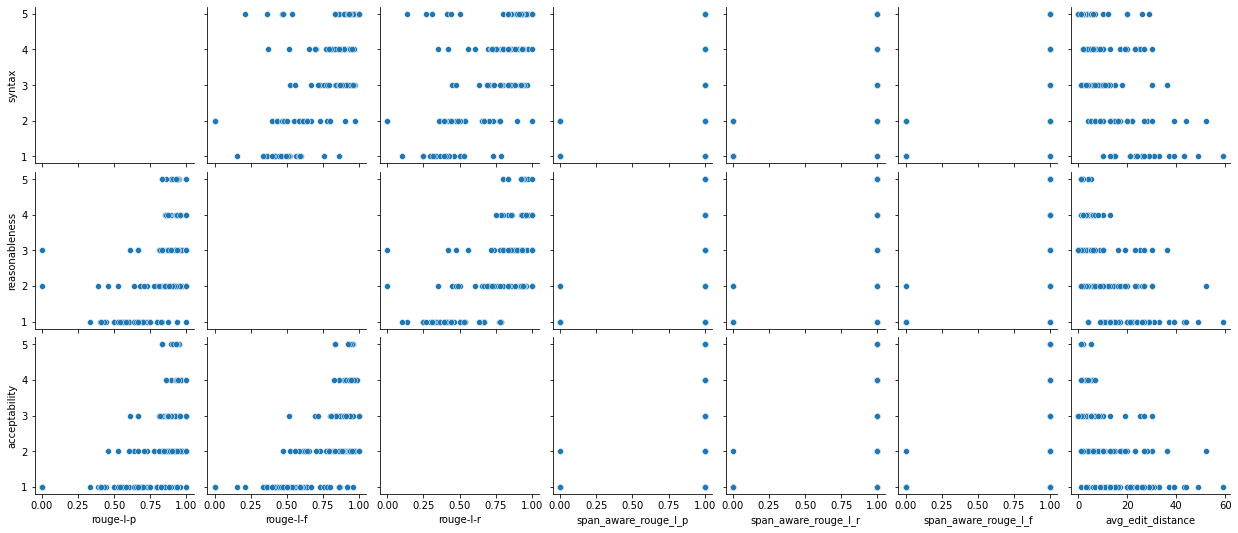

In [34]:
sns.pairplot(example_evals, x_vars = per_example_auto_eval.columns, 
             y_vars=["syntax","reasonableness","acceptability"])

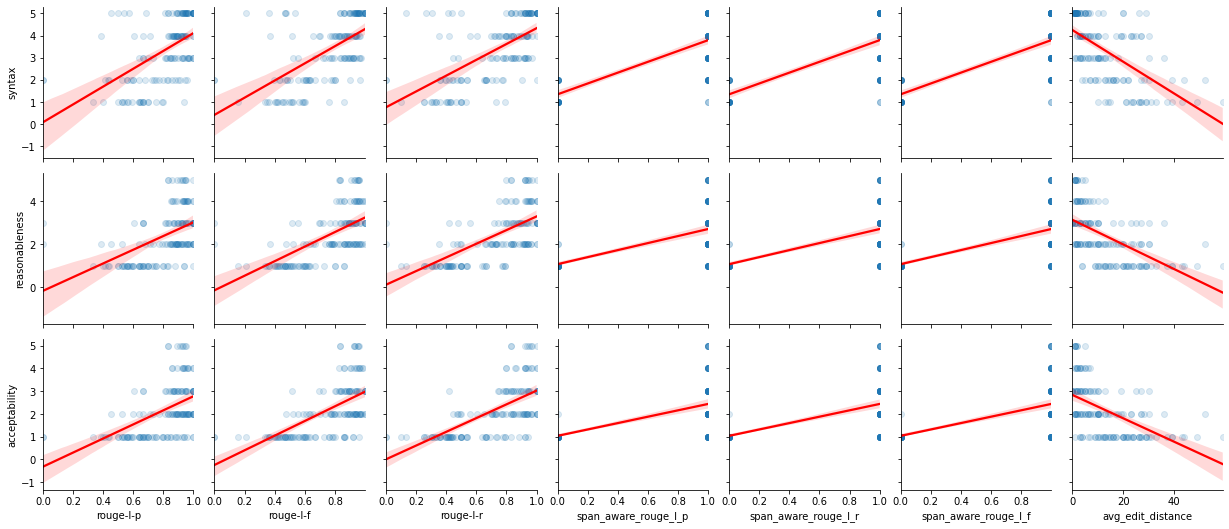

In [36]:
g = sns.PairGrid(example_evals, x_vars = per_example_auto_eval.columns, 
             y_vars=["syntax","reasonableness","acceptability"])
g = g.map(sns.regplot, scatter_kws={'alpha':0.15}, line_kws={'color': 'red'})

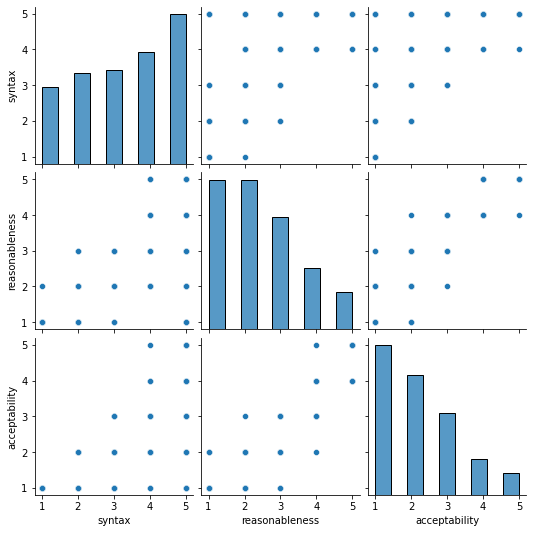

In [39]:
sns.pairplot(example_evals,
             vars=["syntax","reasonableness","acceptability"])
# g = g.map(sns.regplot, scatter_kws={'alpha':0.15}, line_kws={'color': 'red'})

In [41]:
example_evals[["syntax","reasonableness","acceptability"]].pairwise_corr()

,X,Y,method,tail,n,r,CI95%,r2,adj_r2,z,p-unc,BF10,power
0,syntax,reasonableness,pearson,two-sided,150,0.702081,"[0.61, 0.78]",0.492917,0.486018,0.871392,1.388654e-23,3.507e+20,1.0
1,syntax,acceptability,pearson,two-sided,150,0.686804,"[0.59, 0.76]",0.471699,0.464512,0.841880,2.946210e-22,1.758e+19,1.0
2,reasonableness,acceptability,pearson,two-sided,150,0.908724,"[0.88, 0.93]",0.825780,0.823410,1.520153,4.992258e-58,2.63e+54,1.0


^Humans really attatvh